In [25]:
from scipy.io import loadmat
import numpy as np
from numpy import *
from scipy.integrate import odeint
import scipy as sp
import matplotlib.pyplot as plt
import pickle
from control import lqr, ss, c2d
from control.matlab import lsim
from tqdm import tqdm

**The iLQR on the cart and pole system**

Consider the cart-and-pole system here depicted:
<div>
<img src="https://drive.google.com/uc?export=view&id=1Yu5zZ57OEEYZ678yWLaU7h-Wq3M9vV9E" width="200">
</div>
whose dynamics follows the following equations:

\begin{align}
  \ddot{\theta}&=\frac{g \sin(\theta)\,+\,\cos(\theta) \left[ \frac{-F\,-\,m_p\,l\,\dot{\theta}^2 \sin \left(\theta\right)}{m_c\,+\,m_p}\right]-\frac{\mu_p\dot{\theta}}{m_p\,l}}{l\,\left[\frac{4}{3}-\frac{m_p\,cos^2\left(\theta\right)}{m_c\,+\,m_p}\right]}
\end{align}
>>>>>>>>>>>>>>>>>>>>>>>>$(*)$

\begin{align}
  \ddot{p}_c&=\frac{F\,+\,m_p\,l\,\left[\dot{\theta}^2\,\sin\left(\theta\right)\,-\,\ddot{\theta}\,\cos(\theta)\right]}{m_c\,+\,m_p}
\end{align}

where $g = 9.8\,\text{m/sec}$ is the gravitational acceleration, $m_c = 1\,\text{kg}$ is the cart mass, $m_p = 0.1\,\text{kg}$ is the pole mass, $l = 0.5\,\text{m}$ is the half-pole length, $\mu_p = 0.000002$ is the pole on cart friction coefficient.

# 1. Simulate the non-linear cart and pole system applying the provided control input sequence $\bar{u}^{(k)}$ with a sample time of 0.005 sec. Record the resulting state trajectory $\bar{x}^{(k)}$ with an initial state of $\theta=180^°$, $\dot{\theta}=0$, $p_c=0$, $\dot{p_c}=0$. Plot the resulting trajectory.


In [26]:
g = 9.8 # gravitational acceleration
mc = 1  # cart mass [kg]
l = 0.5 # half-pole length [m]
m = 0.1 # pole mass [kg]
miup = 2e-6 # pole friction coefficient

# let's set the input force to 0
F = 0 # N

In [27]:
def cart_and_pole_odeint(x, t, F):
  dxdt = np.zeros_like(x)

  dxdt[0] = x[1] #tetap
  dxdt[1] = (g*sin(x[0])+ cos(x[0])*((-F-m*l*(x[1]**2)*sin(x[0]))/(mc+m))-((miup*x[1])/(m*l))) / (l*((4/3)-((m*(cos(x[0])**2))/(mc+m))))    #teta2p
  dxdt[2] = x[3] #xp
  dxdt[3] = (F+m*l*((x[1]**2)*sin(x[0])-dxdt[1]*cos(x[0])))/(mc+m) #x2p
  return dxdt

In [28]:
uvec = loadmat('ilqr_u.mat')
uvec = uvec['input_traj'].T[0]

In [29]:
time_step=0.005
t0_odeint=0
x0_odeint = np.array([np.pi, 0.0, 0.0, 0.0])
X_odeint=[x0_odeint]

In [30]:
for i in range(len(uvec)):
    t1_odeint = t0_odeint+time_step
    t_odeint = np.array([t0_odeint, t1_odeint])
    F = uvec[i] # this is the only difference
    x_odeint = odeint(cart_and_pole_odeint, x0_odeint, t_odeint, args=(F, ))
    x0_odeint = x_odeint[1]
    X_odeint=np.append(X_odeint, [x0_odeint], axis= 0)

Text(0.5, 1.0, 'p_c(t)')

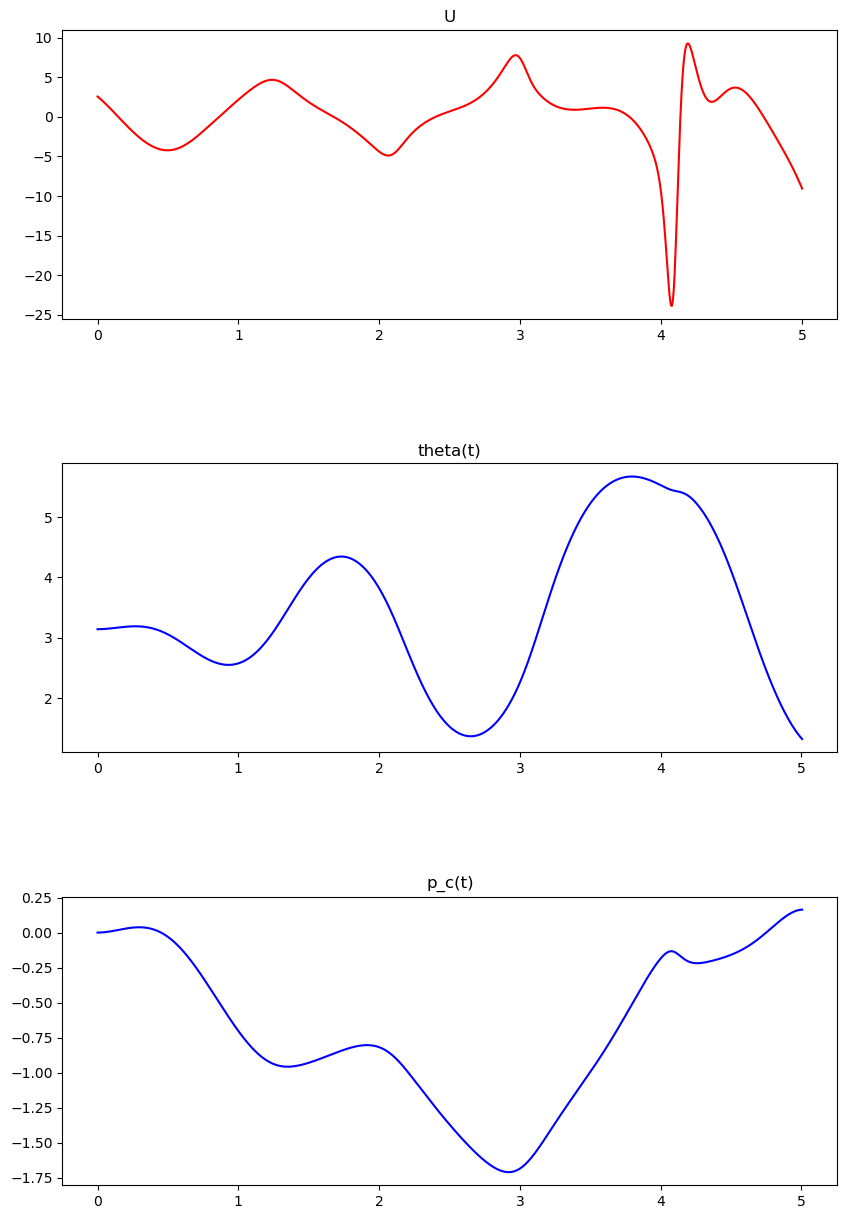

In [31]:
time_sim=np.arange(0.0, 5+2*time_step, time_step)

plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(3)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(time_sim[:-1], uvec, 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(time_sim, X_odeint[:,0], 'b')
axs[1].set_title("theta(t)")

axs[2].plot(time_sim, X_odeint[:,2], 'b')
axs[2].set_title("p_c(t)")

# 2. Linearize the non-linear cart and pole system around the nominal state-input trajectories $\{\bar{x}^{(k)},\bar{u}^{(k)}\}$ previously obtained, and store the time-varying matrices of the linearized system $\{A(k),B(k)\}$




The system will be linearized across the whole trajectory so that the approximation will be as close to reality as possible. Arrays containg the matrices will be created for each time step.

In [32]:
import sympy as sym
from sympy import sin, cos

In [33]:
x1 = sym.Symbol("x1")
x2 = sym.Symbol("x2")
x3 = sym.Symbol("x3")
x4 = sym.Symbol("x4")
F = sym.Symbol("F")
x = [x1,x2,x3,x4]
theta2p = ((g*sin(x[0]))+(cos(x[0])*((-F-(m*l*(x[1]**2)*sin(x[0])))/(mc+m)))-((miup*x[1])/(m*l)))/(l*((4/3)-((m*((cos(x[0]))**2))/(mc+m))))
x2p = (F+(m*l*(((x[1]**2)*sin(x[0]))-((((g*sin(x[0]))+(cos(x[0])*((-F-(m*l*(x[1]**2)*sin(x[0])))/(mc+m)))-((miup*x[1])/(m*l)))/(l*((4/3)-((m*((cos(x[0]))**2))/(mc+m)))))*cos(x[0])))))/(mc+m)

A_time_variant = []
B_time_variant = []

In [34]:
for k in tqdm(range(len(uvec))):
    xeq = X_odeint[k]
    ueq = uvec[k]

    theta2p_linA = []
    for i in range(len(x)): # for each state variable
        lin = sym.diff(theta2p, x[i]) # evaluate the partial derivative
        lin = lin.subs(F, ueq)
        for j in range(len(x)):
            lin = lin.subs(x[j], xeq[j]) # replace equilibrium points
        theta2p_linA.append(lin)
    
    theta2p_linB = sym.diff(theta2p, F)
    for j in range(len(x)):
        theta2p_linB = theta2p_linB.subs(x[j], xeq[j]) # replace equilibrium points
    theta2p_linB.subs(F, ueq)
    
    x2p_linA = []
    for i in range(len(x)):
        lin = sym.diff(x2p, x[i]) # evaluate the partial derivative
        lin = lin.subs(F, ueq)
        for j in range(len(x)):
            lin = lin.subs(x[j], xeq[j]) # replace equilibrium points
        x2p_linA.append(lin)
    
    x2p_linB = sym.diff(x2p, F)
    for j in range(len(x)):
        x2p_linB = x2p_linB.subs(x[j], xeq[j]) # replace equilibrium points
    x2p_linB.subs(F, ueq)
    
    A = np.array([
        [0, 1, 0, 0],
        theta2p_linA,
        [0, 0, 0, 1],
        x2p_linA
    ])
    
    B = np.array([
        [0],
        [theta2p_linB],
        [0],
        [x2p_linB]
    ])
    
    A_time_variant.append(A)
    B_time_variant.append(B)

  0%|          | 4/1001 [00:00<00:24, 39.92it/s]

100%|██████████| 1001/1001 [00:19<00:00, 50.58it/s]


In [35]:
C = np.eye(4)
D = np.zeros(4).reshape(4,1)

# 3. Compute the discrete-time homogeneous representation of the linear time-varying cart and pole system obtained at point 2. and store the matrices of the homogeneous representation



I first have to convert the matrices A and B into their discrete-time representation.

In [36]:
A_time_variant_d = []
B_time_variant_d = []

for i in tqdm(range(len(A_time_variant))):
    S = ss(A_time_variant[i], B_time_variant[i], C, D)
    S_d = c2d(S, time_step)
    
    A_time_variant_d.append(S_d.A)
    B_time_variant_d.append(S_d.B)

  0%|          | 0/1001 [00:00<?, ?it/s]

100%|██████████| 1001/1001 [00:00<00:00, 4116.82it/s]


Knowing the trajectory that the cart-pole system will follow, I can linearize the system across it to have a more accurate linearized representation.

To do so I have to compute the homogeneous representation of the system dynamics: 
- $\hat{x}(k) = \begin{bmatrix} x(k) \\ 1 \end{bmatrix}$
- $\hat{x}(k+1) = \begin{bmatrix} A & 0 \\ 0 & 1 \end{bmatrix} \hat{x}(k) + \begin{bmatrix} B \\ 0 \end{bmatrix} u(k)$.

In [37]:
B_time_variant_d[0].shape

(4, 1)

In [38]:
A_time_variant_d_hom = []
B_time_variant_d_hom = []

for i in tqdm(range(len(A_time_variant))):
    A = A_time_variant_d[i]
    A_hom = np.eye(A.shape[0] + 1)
    A_hom[:4,:4] = A

    B = B_time_variant_d[i]
    B_hom = np.zeros((B.shape[0] + 1, 1))
    B_hom[:4] = B

    A_time_variant_d_hom.append(A_hom)
    B_time_variant_d_hom.append(B_hom)

100%|██████████| 1001/1001 [00:00<00:00, 249657.98it/s]


# 4.    Assume $Q=I$ and $R=1$ , the cost matrices for a swing up cart and pole task, and compute $\hat{Q}(k)=\begin{bmatrix} Q & -q^{{(k)}^\top}\\ -q^{(k)} & d^{(k)}\end {bmatrix}$ where $\bar{x}^{{(k)}^\top} Q \bar{x}^{(k)}=d^{(k)}$ and $2\bar{x}^{{(k)}^\top} Q=2 q^{{(k)}^\top}$ for the entire nominal state trajectory  and store them

I now have to compute the homogeneous representation of $Q$: $\hat{Q}(k) \; \forall k$

I have to do so to find $\pi^{*}(\hat{x}(k)) = -K \hat{x}(k)$ 

solution of: 

$arg min \sum_{k=0}^{H-1} \hat{x}(k)^T \hat{Q}(k) \hat{x}(k) + u(k)^T\hat{R}u(k)$

which is the discrete-time LQR.

In [39]:
Q = np.eye(4,4)
R = 1

In the loop I will calculate:

- $d^{(k)} = \bar{x}^{{(k)}^\top} Q \bar{x}^{(k)}$
- $q^{{(k)}^\top} = \bar{x}^{{(k)}^\top} Q$

That will compose:
$\hat{Q}(k)=\begin{bmatrix} Q & -q^{{(k)}^\top}\\ -q^{(k)} & d^{(k)}\end {bmatrix}$

If $\hat{Q}(k)$ is not positive definite the solution could be to increase the penalty $\hat{Q}(k) = \hat{Q}(k) + \epsilon I$ for deviating from the current state until resulting in $\hat{Q}(k)$ positive semidefinite. 

In this case I will use $\epsilon = 10^{-6}$

In [40]:
Q_hat_time_variant = []
touched_matrices = 0

for i in tqdm(range(len(uvec))):
    bar_x_k = X_odeint[i]
    d_k = bar_x_k.T @ Q @ bar_x_k
    q_k_T = bar_x_k @ Q

    Q_hat = np.zeros((5, 5))
    Q_hat[:4, :4] = Q
    Q_hat[:4,  4] = -q_k_T
    Q_hat[ 4, :4] = -q_k_T.T
    Q_hat[ 4,  4] = d_k

    # Check if Q_hat is positive semidefinite
    sym_check = np.array_equal(Q_hat, Q_hat.T)
    assert sym_check
    is_pos = np.all(np.linalg.eigvals(Q_hat) > 0)
    epsilon = 10e-6

    while not is_pos:
        touched_matrices += 1
        Q_hat = Q_hat + epsilon*np.eye(5,5)
        is_pos = np.all(np.linalg.eigvals(Q_hat) > 0)
        epsilon = 10*epsilon

    Q_hat_time_variant.append(Q_hat)

print(touched_matrices)

100%|██████████| 1001/1001 [00:00<00:00, 24566.70it/s]

511


# 5.   Solve the finite-horizon LQR problem on the linearized version of the system and store the control gain matrices $\{K(k)\}$. Assume that $P_H=\begin{bmatrix} I &0\\0 &0\end{bmatrix}$.

To solve the finite-horizon LQR problem, I have to calculate the time-varying feedback gain matrix $K$, such that $\pi^{*}(x(k)) = - K_k x(k)$ will solve the problem.

If I consider $H$ as the number of elements in the time horizon, I know:
- $P_H = \begin{bmatrix} I &0\\0 &0\end{bmatrix}$
- $K_H = (R+B_H^TP_HB_H)^{-1}B_H^TP_HA_H$

I can then step into the backwards recursive calculation of:
- $P_k = A_K^TP_{k+1}A_K + Q_K - A_K^TP_{k+1}B_{k}(R + B_{k}^TP_{k+1}B_{k})^{-1}B+{k}^TP_{k+1}A_{k}$
- $K_k = (R+B^TP_{k+1}B)^{-1}B^TP_HA$

In [41]:
def calculate_recursive_riccati_gain_and_solution(A, B, Q, P_H):
    assert len(A) == len(B) and len(B) == len(Q)

    K = [None for _ in range(len(A))]
    P = [None for _ in range(len(A))]

    P[-1] = P_H
    K[-1] = np.linalg.inv(R + B[-1].T@P[-1]@B[-1])@B[-1].T@P[-1]@A[-1]

    for k in range(len(A) - 2, -1, -1):
        P[k] = A[k].T @ P[k+1]@A[k] + Q[k] - A[k].T@P[k+1]@B[k]@np.linalg.inv(R + B[k].T@P[k+1]@B[k])@B[k].T@P[k + 1]@A[k]
        K[k] = np.linalg.inv(R + B[k].T@P[k]@B[k])@B[k].T@P[k]@A[k]
    
    return K, P

In [42]:
P_H = np.zeros((5, 5))
P_H[:4,:4] = np.eye(4)

K_time_variant, P_time_variant = calculate_recursive_riccati_gain_and_solution(A_time_variant_d_hom, B_time_variant_d_hom, Q_hat_time_variant, P_H)

# 6. Simulate the non-linear cart and pole system applying the computed control gain matrices $\{K(k)\}$ with a sample time of 0.005 sec. Record the resulting state and control input trajectory with an initial state of $\theta=180^°$, $\dot{\theta}=0$, $p_c=0$, $\dot{p_c}=0$. Plot the resulting trajectories

In [43]:
def simulate_ilqr_round(x0_odeint, nominal_trajectory):
    input_sequence = np.zeros(len(K_time_variant))

    X_odeint_lin = [x0_odeint]

    t0_odeint = 0
    t1_odeint = t0_odeint+time_step
    t_odeint = np.array([t0_odeint, t1_odeint])

    for i in tqdm(range(len(input_sequence))):
        x0_hom = np.concatenate([
            x0_odeint - nominal_trajectory[i],
            [1]
        ], axis=0).reshape(5,1)
        input_sequence[i] = - K_time_variant[i] @ x0_hom + uvec[i]
        F = input_sequence[i]

        x_odeint = odeint(cart_and_pole_odeint, x0_odeint, t_odeint, args=(F, ))
        x0_odeint = x_odeint[1]
        X_odeint_lin.append(x0_odeint)
    
    return input_sequence, X_odeint_lin

In [44]:
x0_odeint = np.array([np.pi, 0, 0, 0])

uvec6, X_odeint_lin = simulate_ilqr_round(x0_odeint, X_odeint)

  0%|          | 0/1001 [00:00<?, ?it/s]/tmp/ipykernel_4625/4153629821.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  input_sequence[i] = - K_time_variant[i] @ x0_hom + uvec[i]
100%|██████████| 1001/1001 [00:28<00:00, 35.08it/s]


Text(0.5, 1.0, 'p_c(t)')

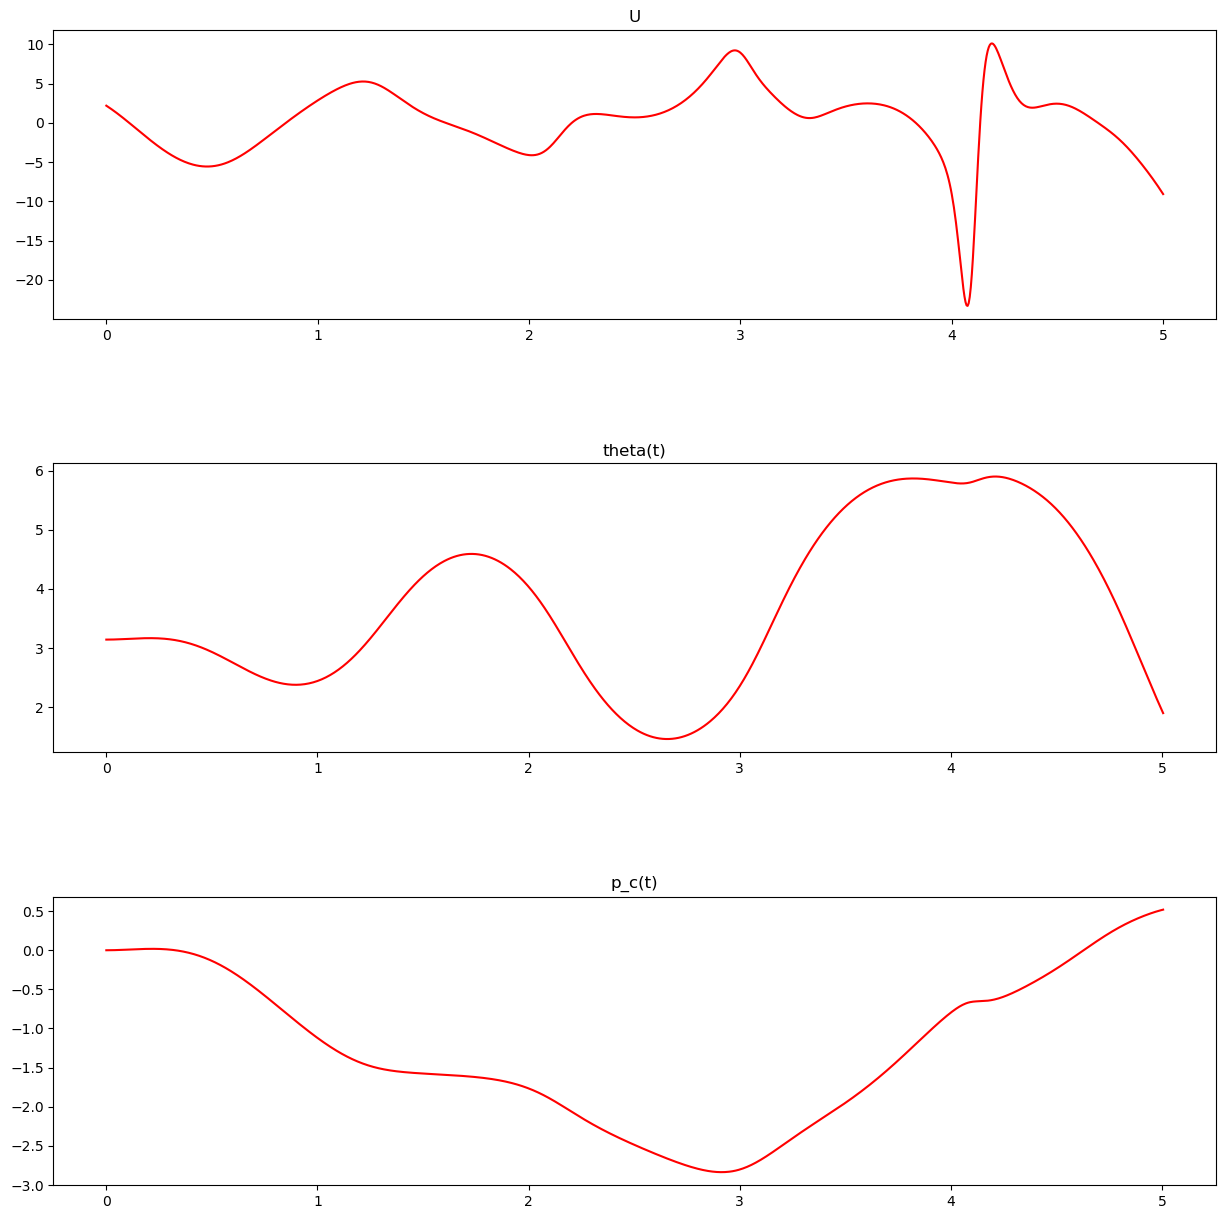

In [45]:
X_odeint_lin = np.array(X_odeint_lin)
time_sim=np.arange(0.0, 5+2*time_step, time_step)

plt.rcParams['figure.figsize'] = [15, 15]
fig, axs = plt.subplots(3)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(time_sim[:-1], uvec6, 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(time_sim, X_odeint_lin[:,0], 'r')
axs[1].set_title("theta(t)")

axs[2].plot(time_sim, X_odeint_lin[:,2], 'r')
axs[2].set_title("p_c(t)")

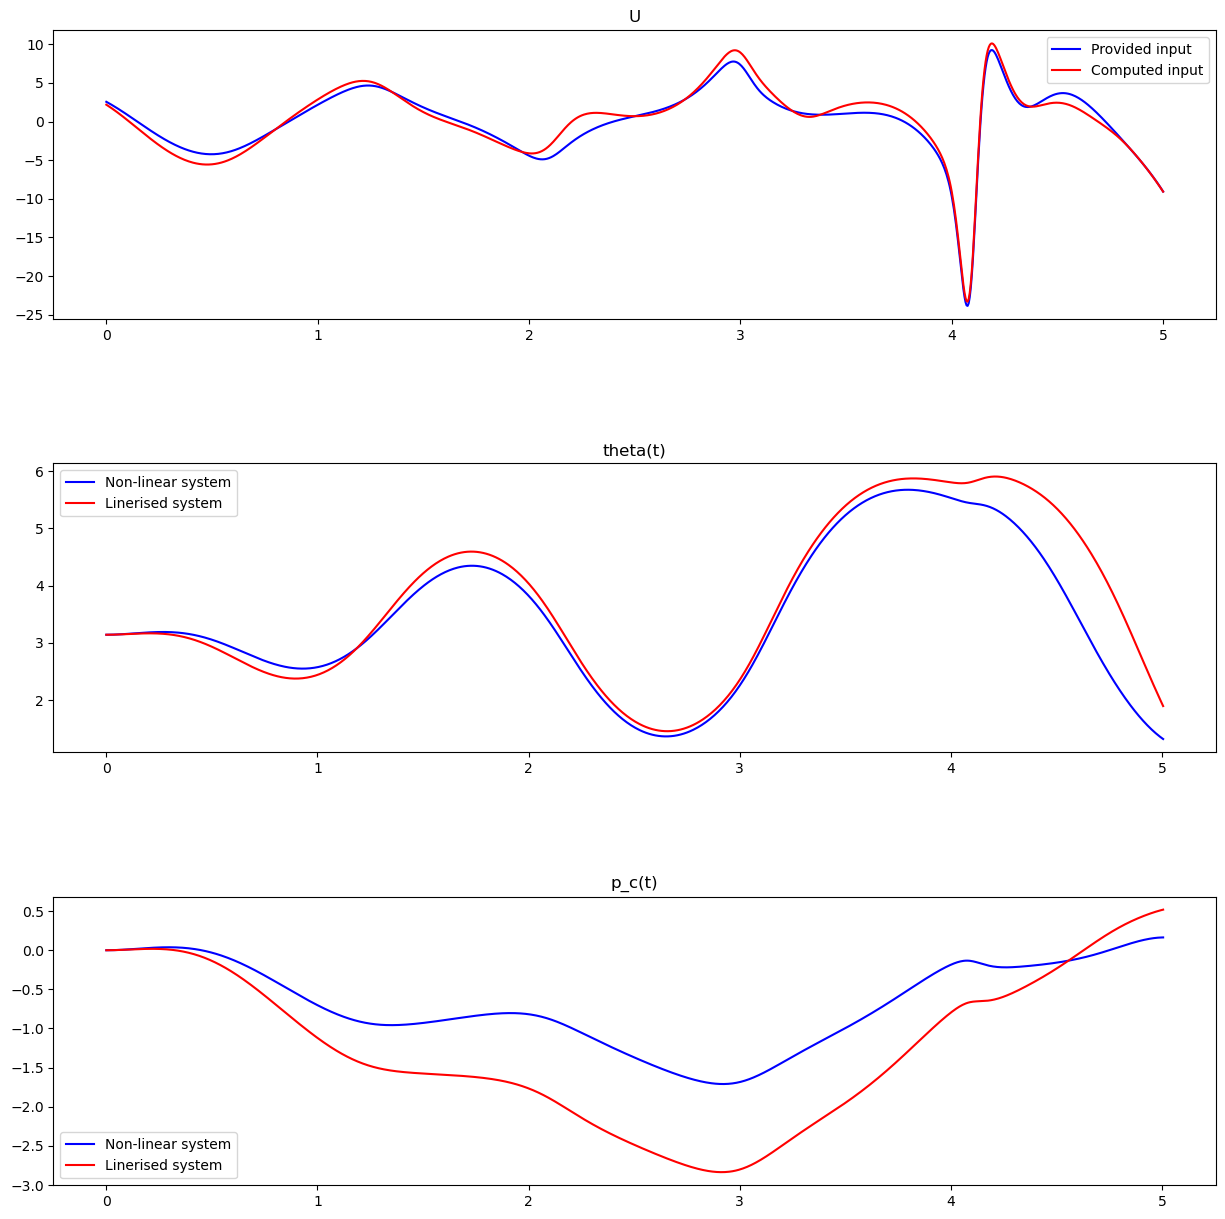

In [46]:
plt.rcParams['figure.figsize'] = [15, 15]
fig, axs = plt.subplots(3)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(time_sim[:-1], uvec, 'b')
axs[0].plot(time_sim[:-1], uvec6, 'r')
axs[0].legend(["Provided input", "Computed input"])
axs[0].set_title("U")

axs[1].plot(time_sim, X_odeint[:,0], 'b')
axs[1].plot(time_sim, X_odeint_lin[:,0], 'r')
axs[1].set_title("theta(t)")
axs[1].legend(["Non-linear system", "Linerised system"])

axs[2].plot(time_sim, X_odeint[:,2], 'b')
axs[2].plot(time_sim, X_odeint_lin[:,2], 'r')
axs[2].set_title("p_c(t)")
axs[2].legend(["Non-linear system", "Linerised system"])

To simulate further rounds I have to do the following:

In [47]:
def simulate_further_ilqr_round(x0_odeint, uvec):
    # Point 2:
    x1 = sym.Symbol("x1")
    x2 = sym.Symbol("x2")
    x3 = sym.Symbol("x3")
    x4 = sym.Symbol("x4")
    F = sym.Symbol("F")
    x = [x1,x2,x3,x4]
    theta2p = ((g*sin(x[0]))+(cos(x[0])*((-F-(m*l*(x[1]**2)*sin(x[0])))/(mc+m)))-((miup*x[1])/(m*l)))/(l*((4/3)-((m*((cos(x[0]))**2))/(mc+m))))
    x2p = (F+(m*l*(((x[1]**2)*sin(x[0]))-((((g*sin(x[0]))+(cos(x[0])*((-F-(m*l*(x[1]**2)*sin(x[0])))/(mc+m)))-((miup*x[1])/(m*l)))/(l*((4/3)-((m*((cos(x[0]))**2))/(mc+m)))))*cos(x[0])))))/(mc+m)

    A_time_variant = []
    B_time_variant = []
    
    for k in tqdm(range(len(uvec))):
        xeq = X_odeint[k]
        ueq = uvec[k]

        theta2p_linA = []
        for i in range(len(x)): # for each state variable
            lin = sym.diff(theta2p, x[i]) # evaluate the partial derivative
            lin = lin.subs(F, ueq)
            for j in range(len(x)):
                lin = lin.subs(x[j], xeq[j]) # replace equilibrium points
            theta2p_linA.append(lin)

        theta2p_linB = sym.diff(theta2p, F)
        for j in range(len(x)):
            theta2p_linB = theta2p_linB.subs(x[j], xeq[j]) # replace equilibrium points
        theta2p_linB.subs(F, ueq)

        x2p_linA = []
        for i in range(len(x)):
            lin = sym.diff(x2p, x[i]) # evaluate the partial derivative
            lin = lin.subs(F, ueq)
            for j in range(len(x)):
                lin = lin.subs(x[j], xeq[j]) # replace equilibrium points
            x2p_linA.append(lin)

        x2p_linB = sym.diff(x2p, F)
        for j in range(len(x)):
            x2p_linB = x2p_linB.subs(x[j], xeq[j]) # replace equilibrium points
        x2p_linB.subs(F, ueq)

        A = np.array([
            [0, 1, 0, 0],
            theta2p_linA,
            [0, 0, 0, 1],
            x2p_linA
        ])

        B = np.array([
            [0],
            [theta2p_linB],
            [0],
            [x2p_linB]
        ])

        A_time_variant.append(A)
        B_time_variant.append(B)
        
    C = np.eye(4)
    D = np.zeros(4).reshape(4,1)
    
    # Point 3:
    A_time_variant_d = []
    B_time_variant_d = []

    for i in tqdm(range(len(A_time_variant))):
        S = ss(A_time_variant[i], B_time_variant[i], C, D)
        S_d = c2d(S, time_step)

        A_time_variant_d.append(S_d.A)
        B_time_variant_d.append(S_d.B)
    
    A_time_variant_d_hom = []
    B_time_variant_d_hom = []

    for i in tqdm(range(len(A_time_variant))):
        A = A_time_variant_d[i]
        A_hom = np.eye(A.shape[0] + 1)
        A_hom[:4,:4] = A

        B = B_time_variant_d[i]
        B_hom = np.zeros((B.shape[0] + 1, 1))
        B_hom[:4] = B

        A_time_variant_d_hom.append(A_hom)
        B_time_variant_d_hom.append(B_hom)
    
    # Point 4:
    Q = np.eye(4,4)
    R = 1
    
    Q_hat_time_variant = []
    touched_matrices = 0

    for i in tqdm(range(len(uvec))):
        bar_x_k = X_odeint[i]
        d_k = bar_x_k.T @ Q @ bar_x_k
        q_k_T = bar_x_k @ Q

        Q_hat = np.zeros((5, 5))
        Q_hat[:4, :4] = Q
        Q_hat[:4,  4] = -q_k_T
        Q_hat[ 4, :4] = -q_k_T.T
        Q_hat[ 4,  4] = d_k

        # Check if Q_hat is positive semidefinite
        sym_check = np.array_equal(Q_hat, Q_hat.T)
        assert sym_check
        is_pos = np.all(np.linalg.eigvals(Q_hat) > 0)
        epsilon = 10e-6

        while not is_pos:
            touched_matrices += 1
            Q_hat = Q_hat + epsilon*np.eye(5,5)
            is_pos = np.all(np.linalg.eigvals(Q_hat) > 0)
            epsilon = 10*epsilon

        Q_hat_time_variant.append(Q_hat)
    
    # Point 5:
    P_H = np.zeros((5, 5))
    P_H[:4,:4] = np.eye(4)

    K_time_variant, P_time_variant = calculate_recursive_riccati_gain_and_solution(A_time_variant_d_hom, B_time_variant_d_hom, Q_hat_time_variant, P_H)
    
    return simulate_ilqr_round(x0_odeint, X_odeint)

In [48]:
uvec62, X_odeint_lin2 = simulate_further_ilqr_round(x0_odeint, X_odeint_lin)

X_odeint_lin2 = np.array(X_odeint_lin2)
time_sim=np.arange(0.0, 5+2*time_step, time_step)

plt.rcParams['figure.figsize'] = [15, 15]
fig, axs = plt.subplots(3)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(time_sim[:-1], uvec6, 'r', label='U(t)')
axs[0].plot(time_sim[:-1], uvec62, 'b', label='U(t)')
axs[0].set_title("U")

axs[1].plot(time_sim, X_odeint_lin[:,0], 'r')
axs[1].plot(time_sim, X_odeint_lin2[:,0], 'b')
axs[1].set_title("theta(t)")

axs[2].plot(time_sim, X_odeint_lin[:,2], 'r')
axs[2].plot(time_sim, X_odeint_lin2[:,2], 'b')
axs[2].set_title("p_c(t)")

for i in range(0,3):
    axs[i].legend([f"First round", f"Second round"])

  0%|          | 0/1002 [00:00<?, ?it/s]

SympifyError: SympifyError: array([3.14159265, 0.        , 0.        , 0.        ])

The optimal policy for the LQR approximation may end up not staying close to the sequence of points around which the LQR approximation was calculated by Taylor expansion. In this case I should update the cost function so that further iterations of the algorithm will continue to stay close to the nominal trajectory.
